In [9]:
import re
from datetime import datetime
import mysql.connector
import matplotlib.pyplot as plt
import pandas as pd

# Read and Parse the Log File:


In [10]:
log_pattern = re.compile(
    r'(?P<ip>\d+\.\d+\.\d+\.\d+) - - \[(?P<timestamp>.*?)\] "(?P<method>\w+) (?P<url>.*?) HTTP/1.1" (?P<status>\d+) (?P<size>\d+|-)'
)

def parse_log_line(line):
    match = log_pattern.match(line)
    if match:
        return match.groupdict()
    return None

log_file = '/home/mti/project/Log/nginx_logs - Copy.txt'  
parsed_logs = []

try:
    with open(log_file, 'r') as file:
        for line in file:
            parsed_line = parse_log_line(line)

#Convert timestamp to datetime object
            if parsed_line:
                parsed_line['timestamp'] = datetime.strptime(parsed_line['timestamp'], '%d/%b/%Y:%H:%M:%S %z')
                parsed_logs.append(parsed_line)
except FileNotFoundError:
    print(f"File not found: {log_file}")
except Exception as e:
    print(f"An error occurred: {e}")

for log in parsed_logs[:5]:
    print(log)


{'ip': '74.240.191.221', 'timestamp': datetime.datetime(2024, 6, 25, 0, 6, 22, tzinfo=datetime.timezone.utc), 'method': 'DELETE', 'url': '/index.html?product_id=585&user_id=218', 'status': '200', 'size': '1974'}
{'ip': '15.89.35.67', 'timestamp': datetime.datetime(2024, 6, 24, 4, 43, 22, tzinfo=datetime.timezone.utc), 'method': 'PUT', 'url': '/index.html?session_id=def456&session_id=mno345&user_id=709', 'status': '301', 'size': '4349'}
{'ip': '158.20.204.46', 'timestamp': datetime.datetime(2024, 6, 21, 14, 54, 22, tzinfo=datetime.timezone.utc), 'method': 'GET', 'url': '/contact.html?session_id=def456', 'status': '200', 'size': '4060'}
{'ip': '158.20.204.46', 'timestamp': datetime.datetime(2024, 6, 21, 14, 54, 22, tzinfo=datetime.timezone.utc), 'method': 'GET', 'url': '/contact.html?session_id=def456', 'status': '200', 'size': '4060'}
{'ip': '238.189.173.32', 'timestamp': datetime.datetime(2024, 6, 21, 21, 33, 22, tzinfo=datetime.timezone.utc), 'method': 'GET', 'url': '/signup?session_i

# Clean the Parsed Data:


In [11]:
## Remove duplicate data using timestamps.Preparing data for storage in databases

#Remove duplicates
unique_logs = {log['timestamp']: log for log in parsed_logs}.values()

cleaned_logs = list(unique_logs)
cleaned_logs


[{'ip': '74.240.191.221',
  'timestamp': datetime.datetime(2024, 6, 25, 0, 6, 22, tzinfo=datetime.timezone.utc),
  'method': 'DELETE',
  'url': '/index.html?product_id=585&user_id=218',
  'status': '200',
  'size': '1974'},
 {'ip': '15.89.35.67',
  'timestamp': datetime.datetime(2024, 6, 24, 4, 43, 22, tzinfo=datetime.timezone.utc),
  'method': 'PUT',
  'url': '/index.html?session_id=def456&session_id=mno345&user_id=709',
  'status': '301',
  'size': '4349'},
 {'ip': '158.20.204.46',
  'timestamp': datetime.datetime(2024, 6, 21, 14, 54, 22, tzinfo=datetime.timezone.utc),
  'method': 'GET',
  'url': '/contact.html?session_id=def456',
  'status': '200',
  'size': '4060'},
 {'ip': '238.189.173.32',
  'timestamp': datetime.datetime(2024, 6, 21, 21, 33, 22, tzinfo=datetime.timezone.utc),
  'method': 'GET',
  'url': '/signup?session_id=abc123&session_id=ghi789',
  'status': '500',
  'size': '2661'},
 {'ip': '190.111.164.7',
  'timestamp': datetime.datetime(2024, 6, 26, 9, 3, 22, tzinfo=datet

# Store the Data in a MySQL Database:



In [12]:
# Database connection
db_conn = mysql.connector.connect(
    host="localhost",
    user="localhost",
    password="localhost",
    database="localhost"
)
cursor = db_conn.cursor()

cursor.execute('''
    CREATE TABLE IF NOT EXISTS nginx_logs (
        id INT AUTO_INCREMENT PRIMARY KEY,
        ip VARCHAR(15),
        timestamp DATETIME,
        method VARCHAR(10),
        url TEXT,
        status INT,
        size INT
    )
''')

# Inserting cleaned data into the table
for log in cleaned_logs:
    cursor.execute('''
        INSERT INTO nginx_logs (ip, timestamp, method, url, status, size)
        VALUES (%s, %s, %s, %s, %s, %s)
    ''', (log['ip'], log['timestamp'], log['method'], log['url'], log['status'], log['size']=='-'))

db_conn.commit()
cursor.close()
db_conn.close()

ProgrammingError: 1049 (42000): Unknown database 'Log'

# Generate Visualizations:



/tmp/ipykernel_3460/3651937253.py:9: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  logs_df = pd.read_sql(query, db_conn)


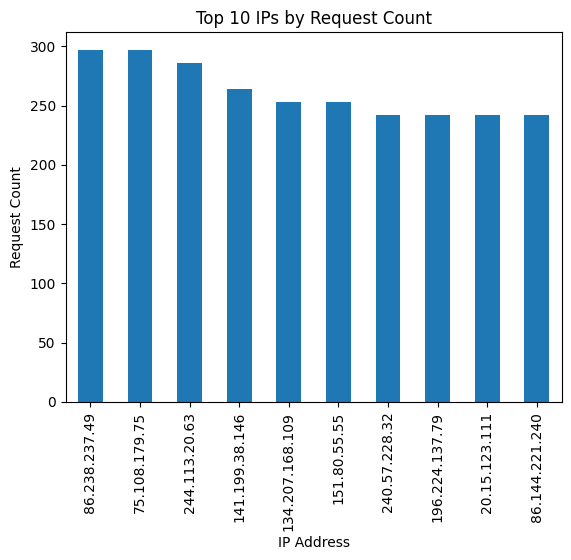

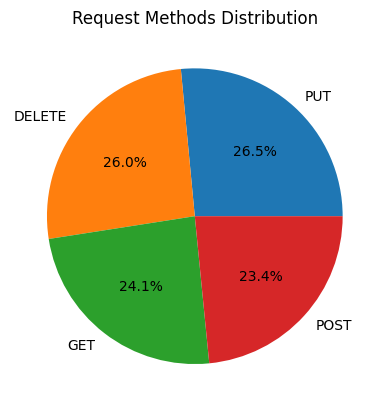

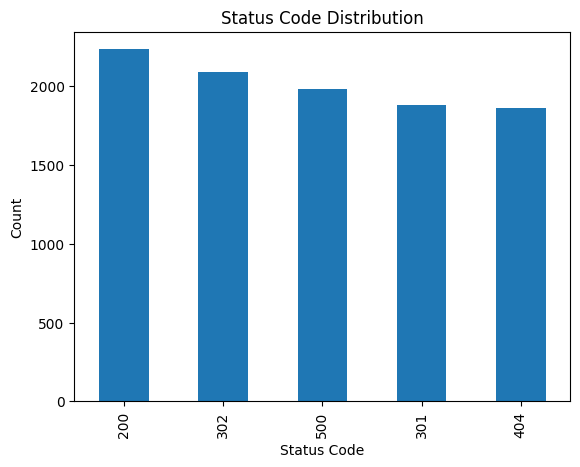

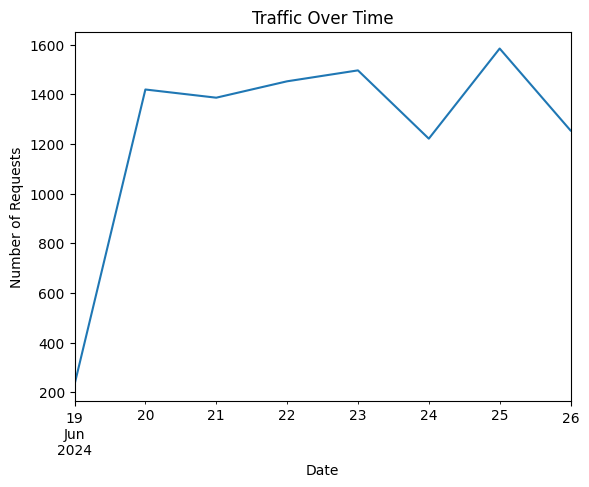

In [ ]:
#Fetching data from MySQL database
db_conn = mysql.connector.connect(
    host="localhost",
    user="username",
    password="password",
    database="database"
)
query = "SELECT * FROM nginx_logs"
logs_df = pd.read_sql(query, db_conn)
db_conn.close()
#Visualization: Number of requests per IP address
ip_counts = logs_df['ip'].value_counts().head(10)
ip_counts.plot(kind='bar', title='Top 10 IPs by Request Count')
plt.xlabel('IP Address')
plt.ylabel('Request Count')
plt.show()
#Visualization: Request methods distribution
method_counts = logs_df['method'].value_counts()
method_counts.plot(kind='pie', title='Request Methods Distribution', autopct='%1.1f%%')
plt.ylabel('')
plt.show()
#Visualization: Status code distribution
status_counts = logs_df['status'].value_counts()
status_counts.plot(kind='bar', title='Status Code Distribution')
plt.xlabel('Status Code')
plt.ylabel('Count')
plt.show()
#Visualization: Traffic over time
logs_df.set_index('timestamp', inplace=True)
logs_df['method'].resample('D').count().plot(title='Traffic Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Requests')
plt.show()
